In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf')

import keras
print (keras.__version__, keras.backend.backend())

import tensorflow as tf
tf.python.control_flow_ops = tf

Using TensorFlow backend.


1.0.7 tensorflow


In [4]:
import h5py
import numpy as np
import shutil
import glob, os

from IPython.display import SVG
from matplotlib import pyplot as plt
from keras.models import Sequential, model_from_json
from keras.layers import Activation, Conv2D, Dense, Dropout,  Flatten
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
# from keras.utils.visualize_util import model_to_dot
from skimage import io, color, feature, transform
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [4]:
np.random.seed(123)

In [5]:
FILTER_SIZE = 3
POOLING_SIZE = 2
NB_FILTERS = 32
BATCH_SIZE = 16

IMAGE_SIZE = 150
NUM_IMAGES = 25000
WEIGHTS = 'model_preprocessed_images.h5'
MODEL = 'model.json'

In [6]:
def preprocess_images():
    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1./255)

    # this is a generator that will read pictures found in
    # subfolers of 'data/train', and indefinitely generate
    # batches of augmented image data
    train_generator = train_datagen.flow_from_directory(
            '/data/smannan/train/train/',  # this is the target directory
            target_size=(IMAGE_SIZE, IMAGE_SIZE),  # all images will be resized to 150x150
            batch_size=BATCH_SIZE,
            class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels
    
    # this is a similar generator, for validation data
    validation_generator = test_datagen.flow_from_directory(
            '/data/smannan/train/validation/',
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

    return (train_generator, validation_generator)

In [7]:
def save_model(model, model_arch, model_weights):
    model_json = model.to_json()
    with open(model_arch, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_weights)
    print("Saved model to disk")

In [8]:
def load_model(model_arch, model_weights):
    json_file = open(model_arch, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    # load weights into new model
    loaded_model.load_weights(model_weights)
    print("Loaded model from disk")
    
    return (loaded_model)              

In [9]:
def define_model_arch():
    '''FILTER_SIZE = 3
    POOLING_SIZE = 2
    NB_FILTERS = 32'''
    
    # input layer
    model = Sequential()
    model.add(Conv2D(NB_FILTERS, FILTER_SIZE, FILTER_SIZE, activation='relu', \
                     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(POOLING_SIZE, POOLING_SIZE)))

    # layer 2
    model.add(Conv2D(NB_FILTERS, FILTER_SIZE, FILTER_SIZE, activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(POOLING_SIZE, POOLING_SIZE)))

    # layer 3
    model.add(Conv2D(NB_FILTERS*2, FILTER_SIZE, FILTER_SIZE, activation='relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(POOLING_SIZE, POOLING_SIZE)))

    # connected layer
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    # what does the activation do?
    model.add(Activation('sigmoid'))
    
    return (model)

In [10]:
def train_model(model, training_generator):
    # how to choose loss function?
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    
    model.fit_generator(
            generator=training_generator,
            samples_per_epoch=2000,
            nb_epoch=50)
    
    os.chdir('/home/smannan/finalproject/')
    model.save_weights(WEIGHTS) 
    with open(MODEL, "w") as json_file: json_file.write(model.to_json())

In [11]:
os.chdir('/data/smannan/train/validation/cat')
test_cats = len(glob.glob("*.jpg"))

os.chdir('../dog/')
test_dogs = len(glob.glob("*.jpg"))

assert test_cats + test_dogs == 0.3 * NUM_IMAGES

os.chdir('/data/smannan/train/train/cat')
train_cat = len(glob.glob("*.jpg"))

os.chdir('../dog/')
train_dog = len(glob.glob("*.jpg"))

assert train_cat + train_dog == 0.7 * NUM_IMAGES

os.chdir('/home/smannan/finalproject/')

### Create training/testing generators for Keras

In [16]:
training_generator, validation_generator = preprocess_images()

Found 17500 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


### Define model architecture and train model

In [17]:
model = define_model_arch()

In [33]:
train_model(model, training_generator)

Epoch 1/50
2000/2000 [==============================] - 61s - loss: 0.6954 - acc: 0.5040      

/opt/conda/lib/python3.5/site-packages/keras/engine/training.py:1463: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 10/50
2000/2000 [==============================] - 66s - loss: 0.6199 - acc: 0.6540     

In [18]:
loaded_model = load_model('/home/smannan/finalproject/models/model.json', 
                          '/home/smannan/finalproject/models/model_preprocessed_images.h5')

loaded_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
score = loaded_model.evaluate_generator(validation_generator, val_samples=2000)
score

Loaded model from disk


[0.49341244530677797, 0.77249999999999996]

In [5]:
# SVG(model_to_dot(loaded_model).create(prog='dot', format='svg'))

10/10 [==============================] - 0s


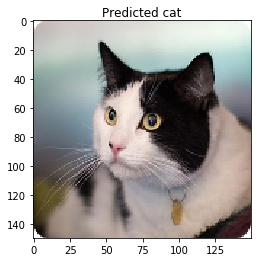

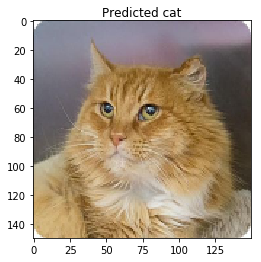

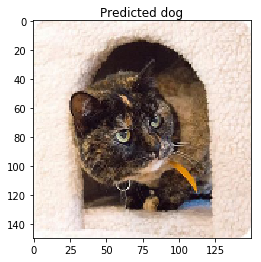

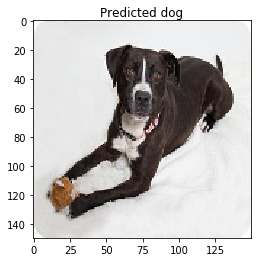

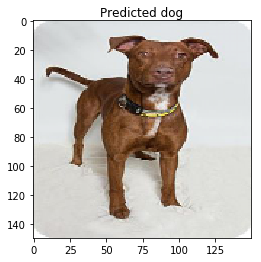

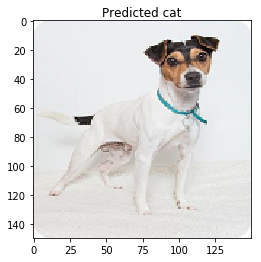

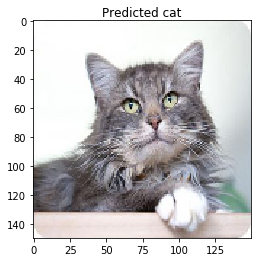

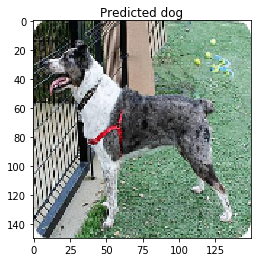

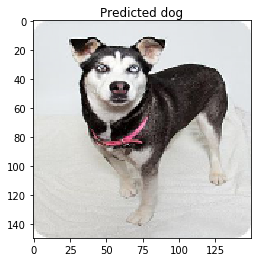

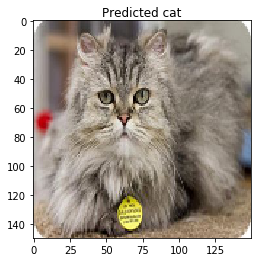

In [19]:
os.chdir('/home/smannan/finalproject/test/')
files = glob.glob('*.jpg')
test_im = []
for im in files:
    test_im.append(transform.resize(io.imread(im), (IMAGE_SIZE, IMAGE_SIZE)))
test_im = np.reshape(np.array(test_im), (len(test_im), IMAGE_SIZE, IMAGE_SIZE, 3))
classes = loaded_model.predict_classes(test_im)
labels = ['cat', 'dog']

for im, pred in zip(test_im, classes):
    plt.imshow(im)
    plt.title('Predicted ' + labels[pred])
    plt.show();